In [1]:
using Random
using Distributions
using LinearAlgebra
include("../../Inversion/Plot.jl")
include("../../Inversion/RWMCMC.jl")
include("../../Inversion/SMC.jl")
include("../../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ::Array{Float64,1})  
    return [θ[1] ;]
end

function p1_aug(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* SMC method: $10^3$ particles and $10^2$ uniform steps is also applied for comparison. 
* UKI method: $2$ initial conditions are considered, which are $\theta_0\sim\mathcal{N}(-1, 0.5^2)$ and $\theta_0\sim\mathcal{N}(1, 0.5^2)$. We find that only the hyperbola discontinuous problem is sensitive to the initial covariance for the UKI. The hyperparameters of UKI are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$.

In [3]:
function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, 
                        Run_EKS = false, Run_SMC = false, Run_MCMC = false, plot_every = 1)
    @info "Start "
    forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)
    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    


    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 30
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    
    ukiobjs = [] 
    for N_modes = 1:3
        
        θ0_w  = fill(1.0, N_modes)/N_modes
        θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

        Random.seed!(111);
        for m = 1:N_modes
            θ0_mean[m, :]    .= rand(Normal(0, σ_0), N_θ)
            θθ0_cov[m, :, :] .= Array(Diagonal(fill(σ_0^2, N_θ)))
        end
        @info "Run GMKI with ", N_modes, " θ0_mean = ", θ0_mean
        ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
        push!(ukiobjs, ukiobj) 
    
    end


    if Run_MCMC
        # compute posterior distribution by MCMC
        logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
        step_length = 1.0
        n_iter , n_burn_in= 5000000, 1000000
        us = RWMCMC_Run(logρ, μ0, step_length, n_iter)
    end
    
    # compute posterior distribution by SMC
    if Run_SMC
        N_ens = 100
        M_threshold = Float64(N_ens)
        step_length = 1.0
        smcobj = SMC_Run(s_param, forward,
        μ0, Σ0, 
        y, Σ_η,
        N_ens, 
        step_length,
        M_threshold,
        N_iter) 
    end

    if Run_EKS
        N_ens  = 1000
        eksobj = EKS_Run(s_param, forward, 
        μ0, Σ0,
        N_ens,
        y, Σ_η,
        N_iter)
        @info "EKS large J t = ", sum(eksobj.Δt)
    end
    
    
    # visualization 
    plot_every = 10
    linestyles = ["o"; "x"; "s"]
    # Visualize different iterations
    for iter  = [1:plot_every:N_iter; N_iter]
        nrows, ncols = 2, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey="row", figsize=(15,10))
        
        
        
        
        
        
        
        # plot UKI results 
        for N_modes = 1:3
            
            
            if Run_MCMC
                # plot MCMC results 
                ax[1, N_modes].hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="grey", linewidth=2)
            end


            if Run_SMC
                # plot SMC results 
                θ = smcobj.θ[end]
                weights = smcobj.weights[end]
                ax[1, N_modes].hist(θ, bins = 10, weights = weights, density = true, histtype = "step", label="SMC", color="maroon")  
            end
            
            
            if Run_EKS
                # plot EKS results 
                θ = eksobj.θ[end]
                ax[1, N_modes].hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
            end


            
            
            Nx = 1000
            xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
            θ_min = minimum(ukiobjs[N_modes].θ_mean[iter][:,1] .- 5sqrt.(ukiobjs[N_modes].θθ_cov[iter][:,1,1]))
            θ_max = maximum(ukiobjs[N_modes].θ_mean[iter][:,1] .+ 5sqrt.(ukiobjs[N_modes].θθ_cov[iter][:,1,1]))
        
            for i =1:N_modes
                xxs[i, :], zzs[i, :] = Gaussian_1d(ukiobjs[N_modes].θ_mean[iter][i,1], ukiobjs[N_modes].θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
                zzs[i, :] *= exp(ukiobjs[N_modes].logθ_w[iter][i])
                
                ax[1, N_modes].plot(fill(ukiobjs[N_modes].θ_mean[iter][i,1], 11), LinRange(0,1,11), marker=linestyles[i], fillstyle="none", markevery=5, color="C"*string(i))


                # ax[1, N_modes].plot(xxs[i,:], zzs[i,:], marker= linestyles[i], linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="modal "*string(i))
            end
            ax[1, N_modes].plot(xxs[1,:], sum(zzs, dims=1)', linestyle="-", color="C0", fillstyle="none", markevery=100, label="GMKI", linewidth=2)
        


        
            

            

            ax[1, N_modes].legend()
            
            
            θ_w = exp.(hcat(ukiobjs[N_modes].logθ_w...))
            for i =1:N_modes
                ax[2, N_modes].plot(Array(1:N_iter), θ_w[i, 1:N_iter], marker=linestyles[i], color = "C"*string(i), fillstyle="none", markevery=5, label= "mode "*string(i))
            end
            ax[2, N_modes].legend()
            ax[2, N_modes].set_xlabel("Iterations")
        end
        ax[1, 1].set_ylabel("Densities")
        ax[2, 1].set_ylabel("Weights")
        
        fig.tight_layout()
        fig.savefig("1D-density-"*string(σ_η)*"-"*string(iter)*".pdf")
    end
    
    
    
end

Posterior_Plot (generic function with 1 method)

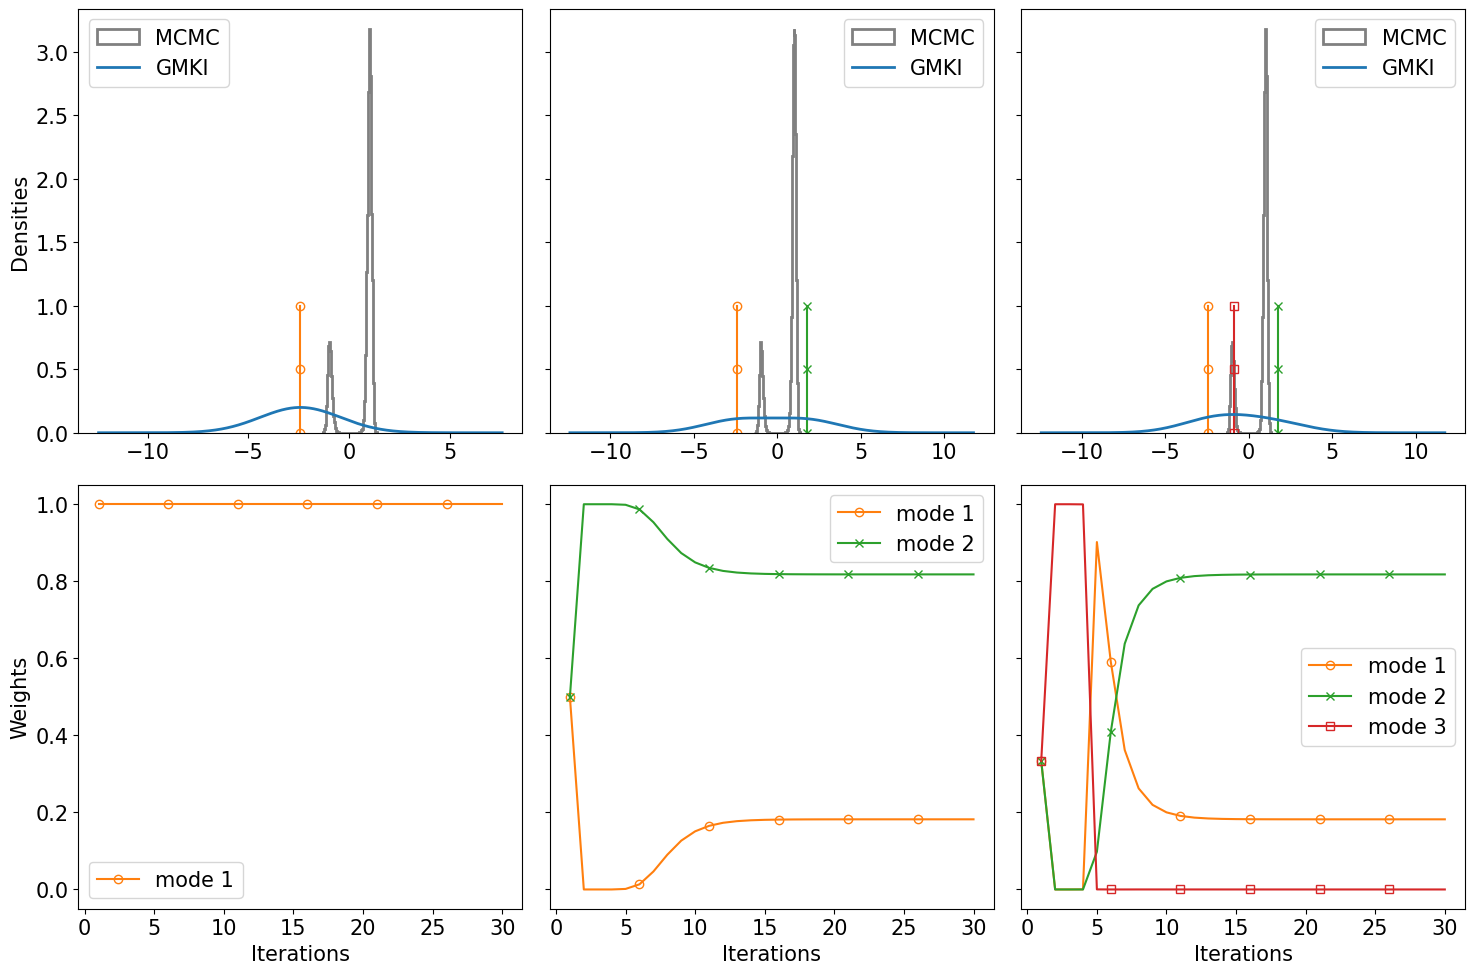

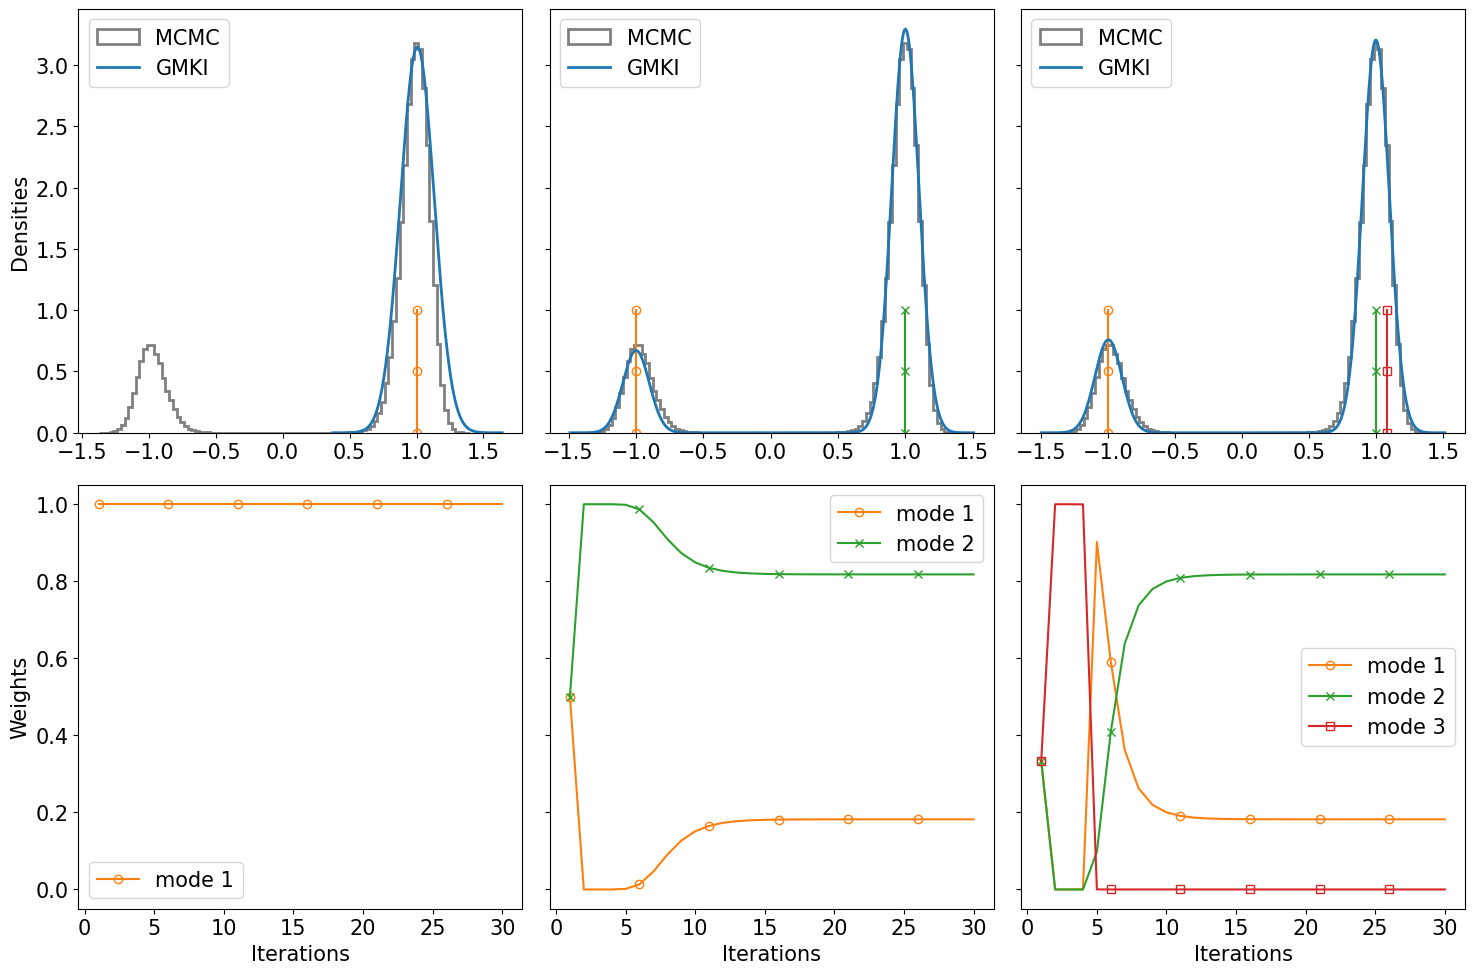

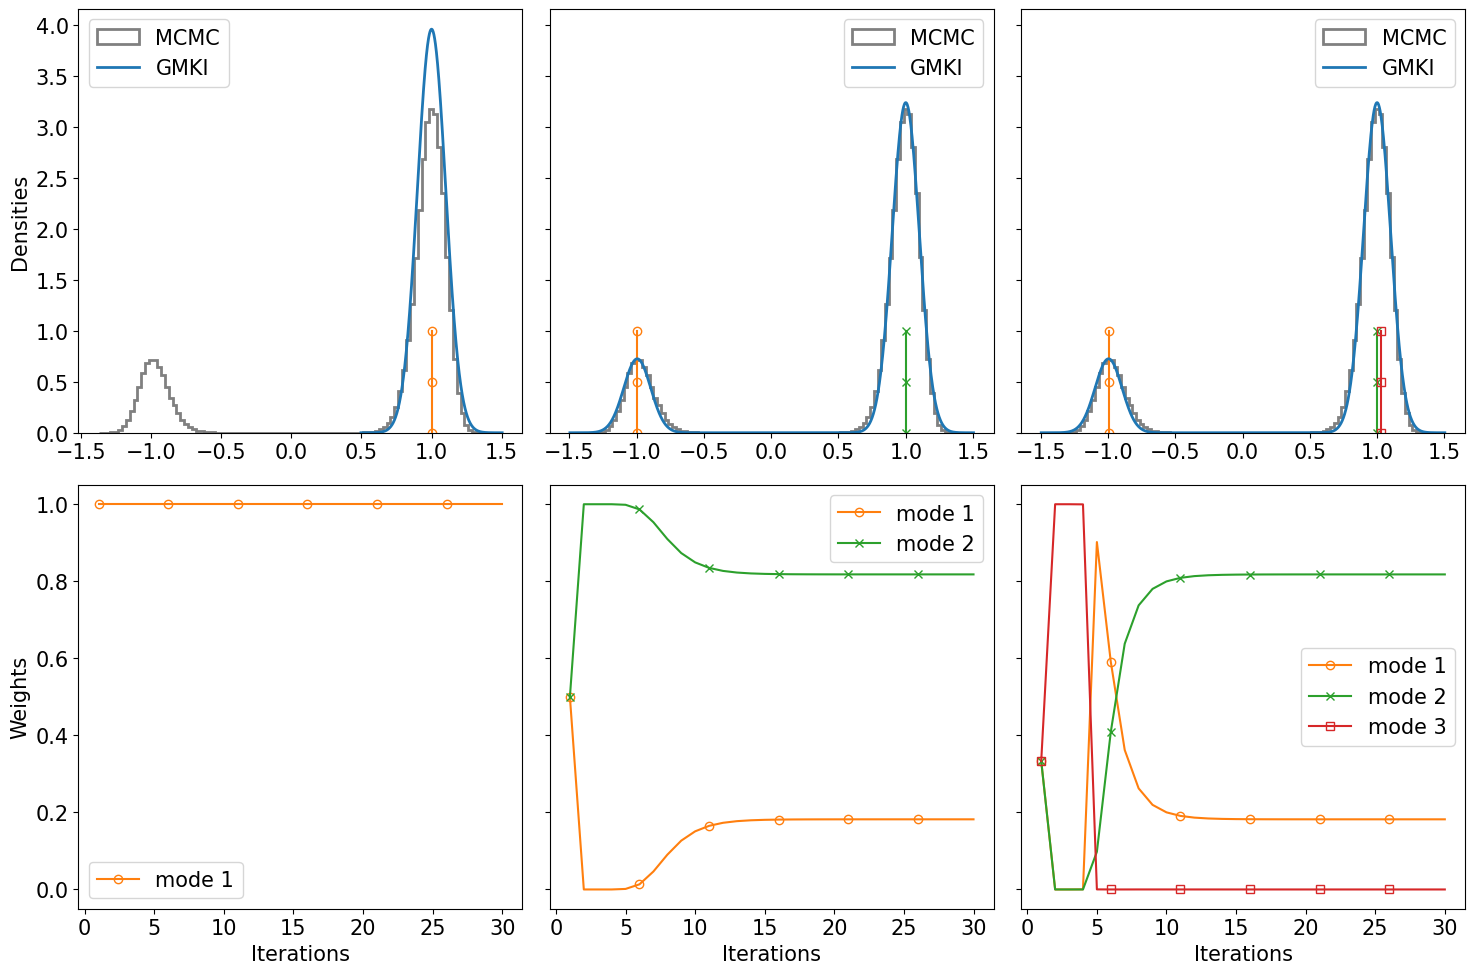

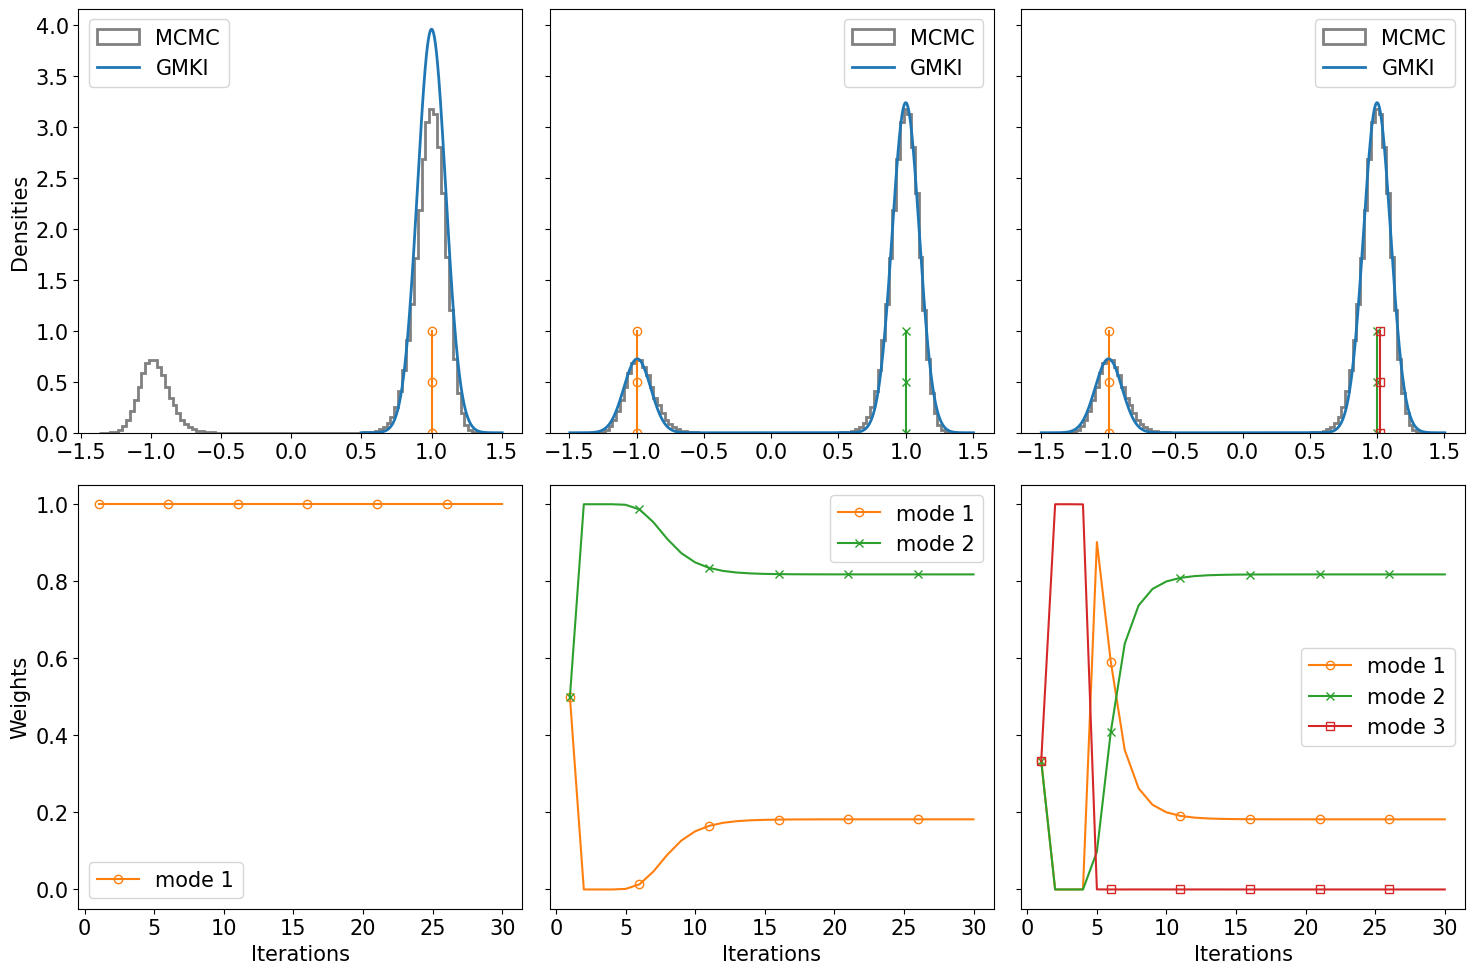

┌ Info: Start 
└ @ Main In[3]:3
┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:6

In [4]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, Run_SMC = false, plot_every = 5) 

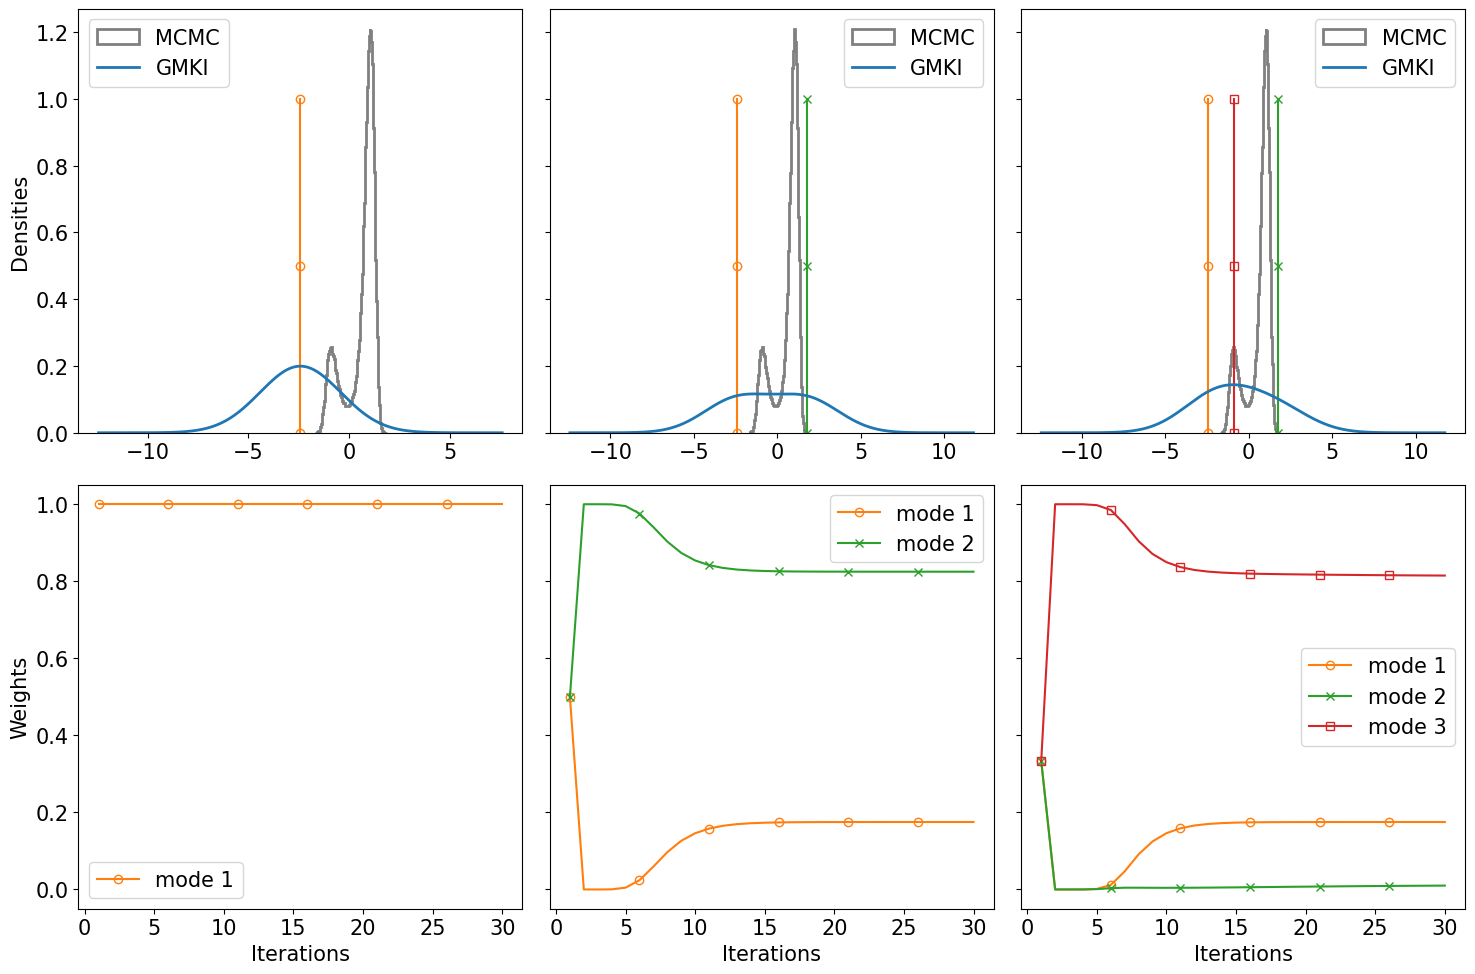

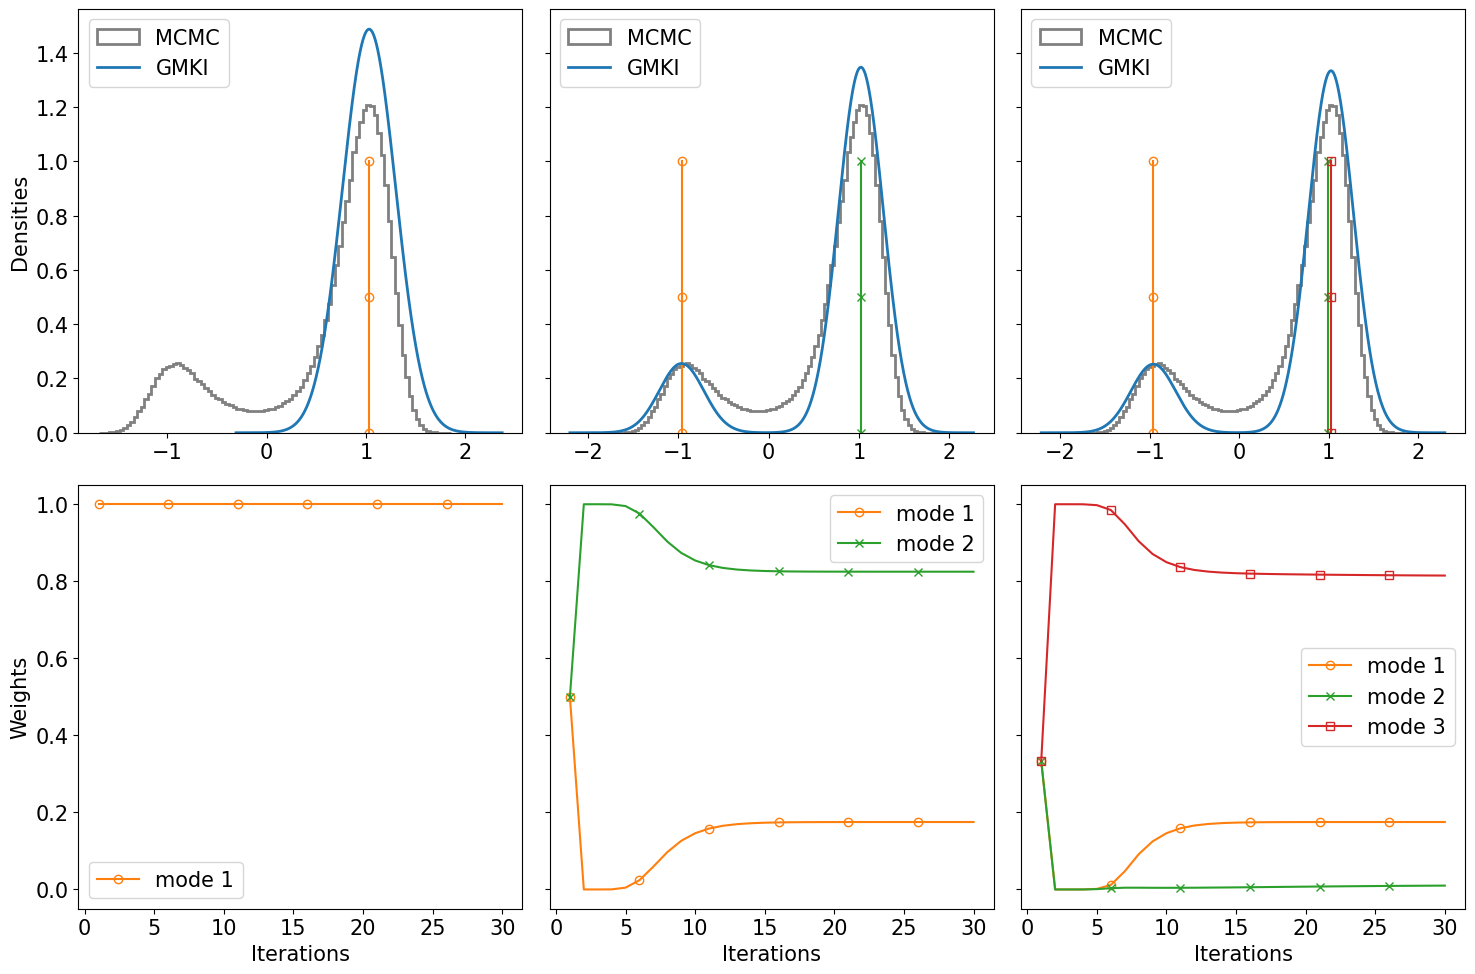

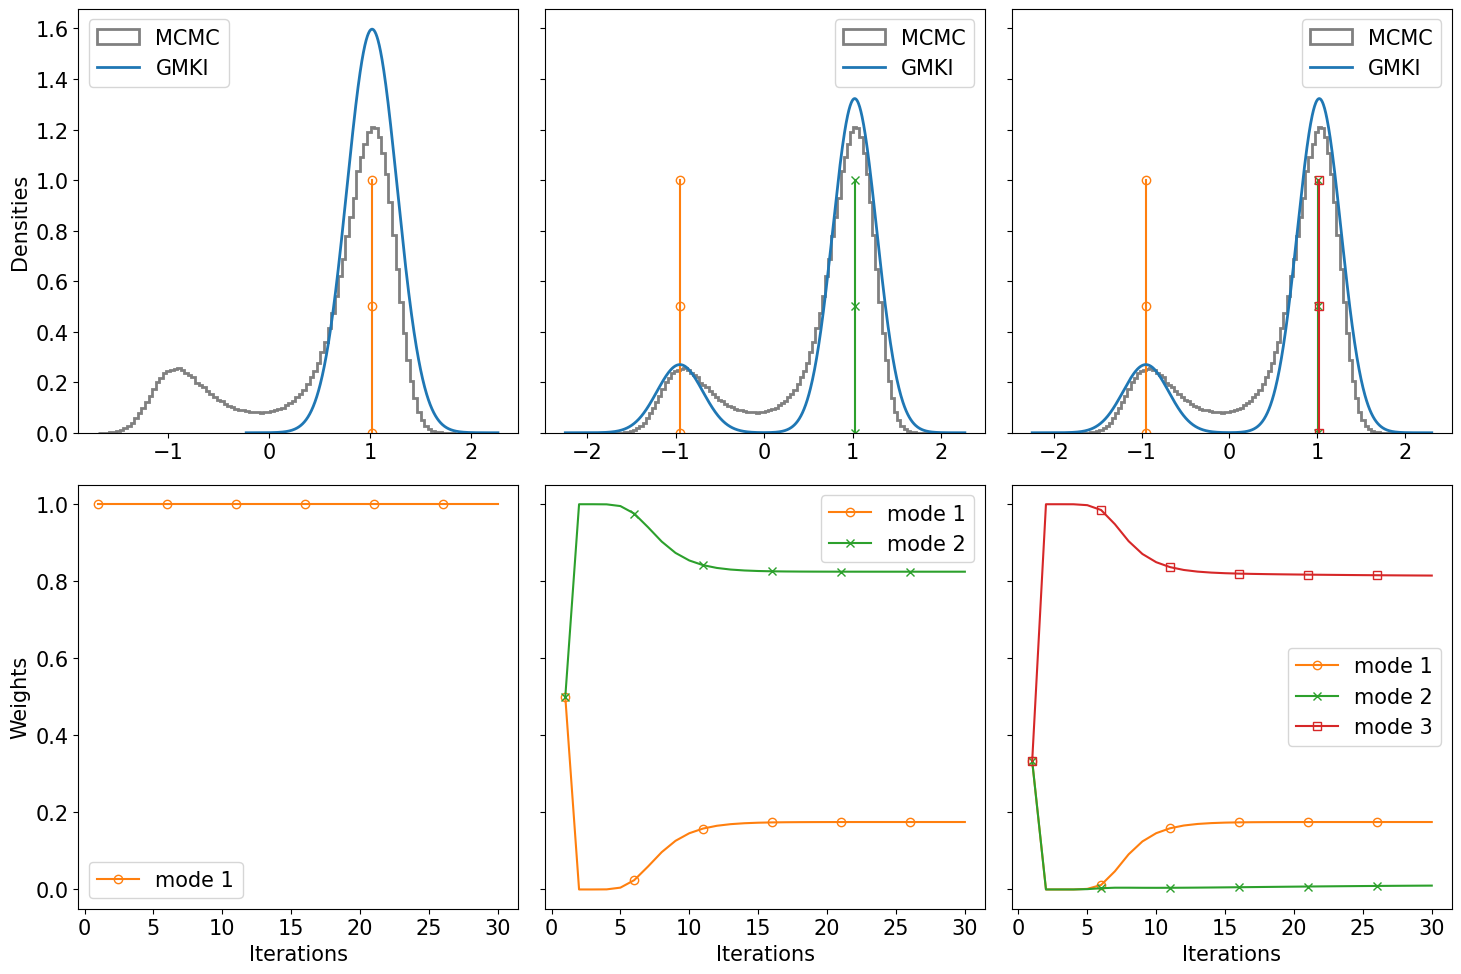

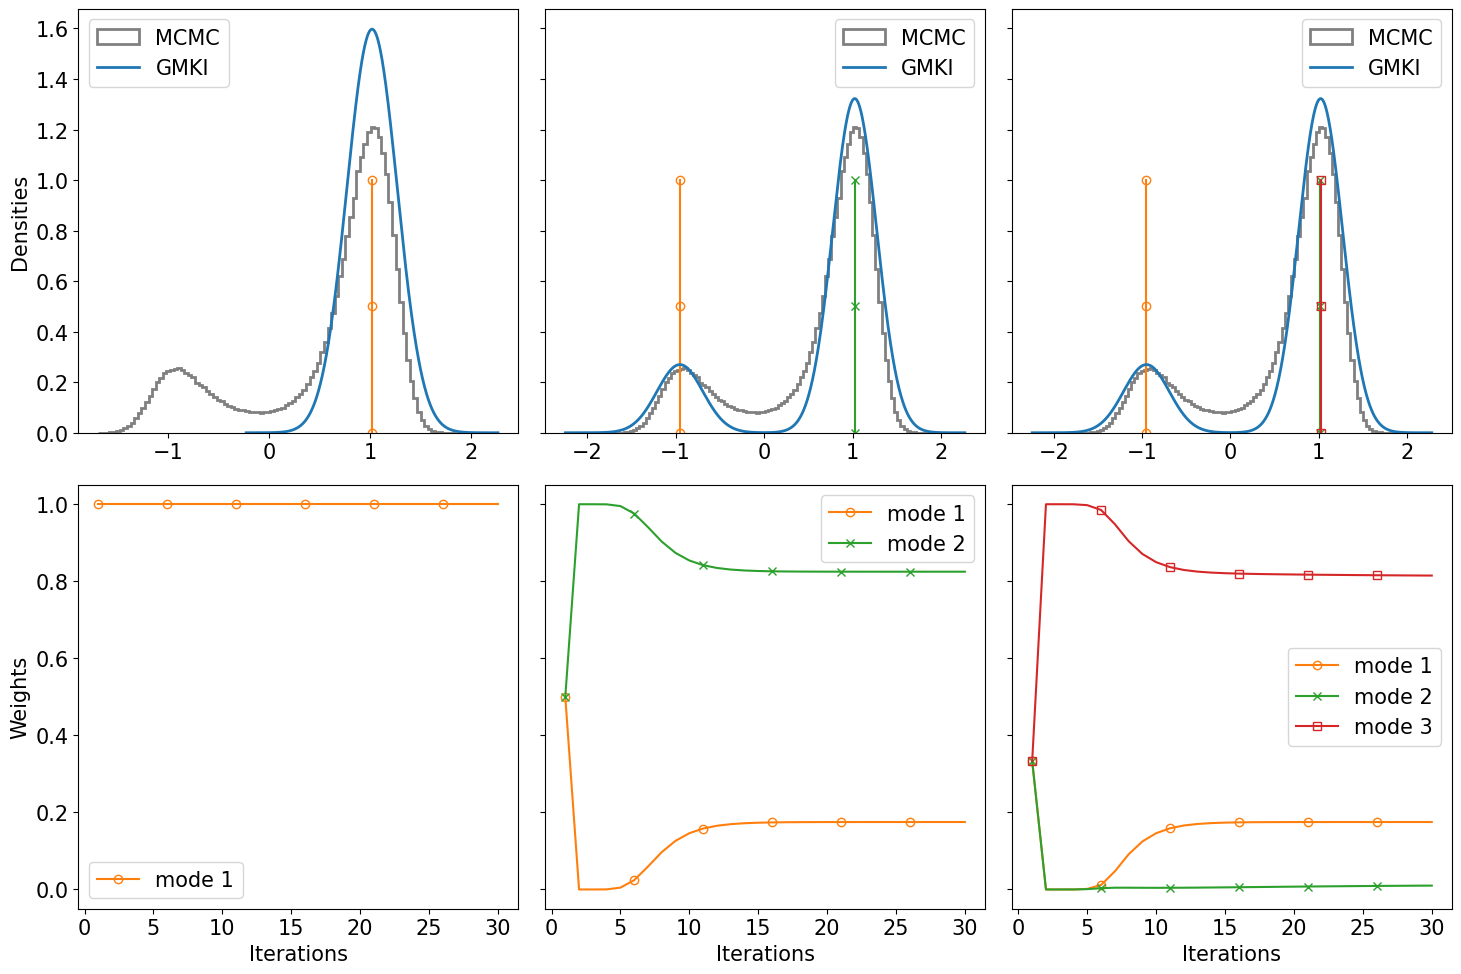

┌ Info: Start 
└ @ Main In[3]:3
┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81


In [5]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.2,  σ_0 = 2.0, Run_MCMC = true, Run_SMC = false, plot_every = 5) 

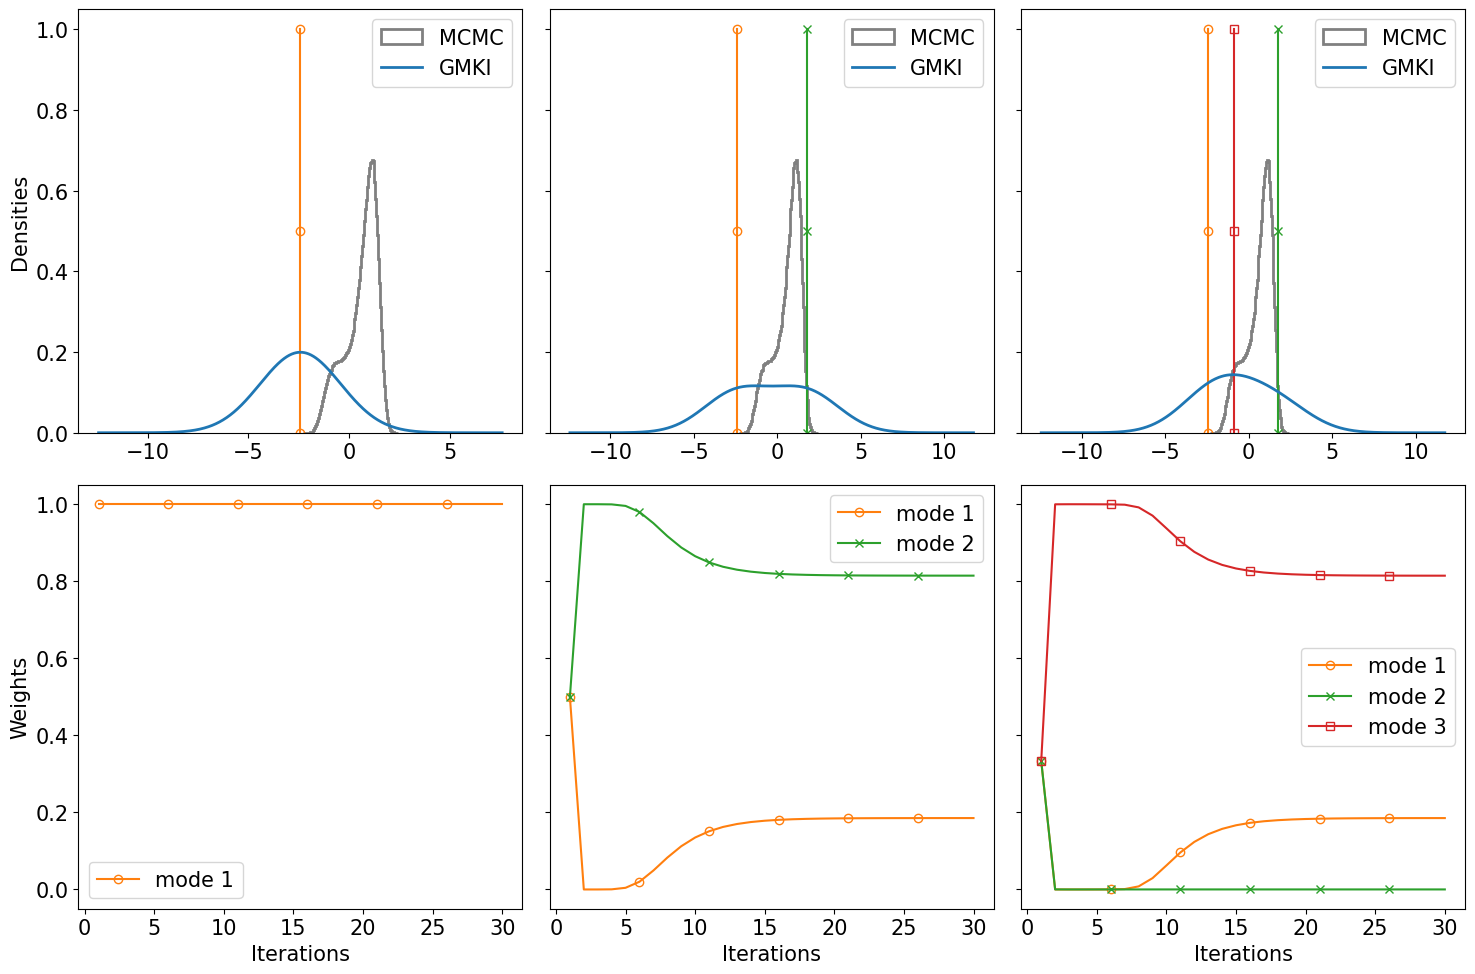

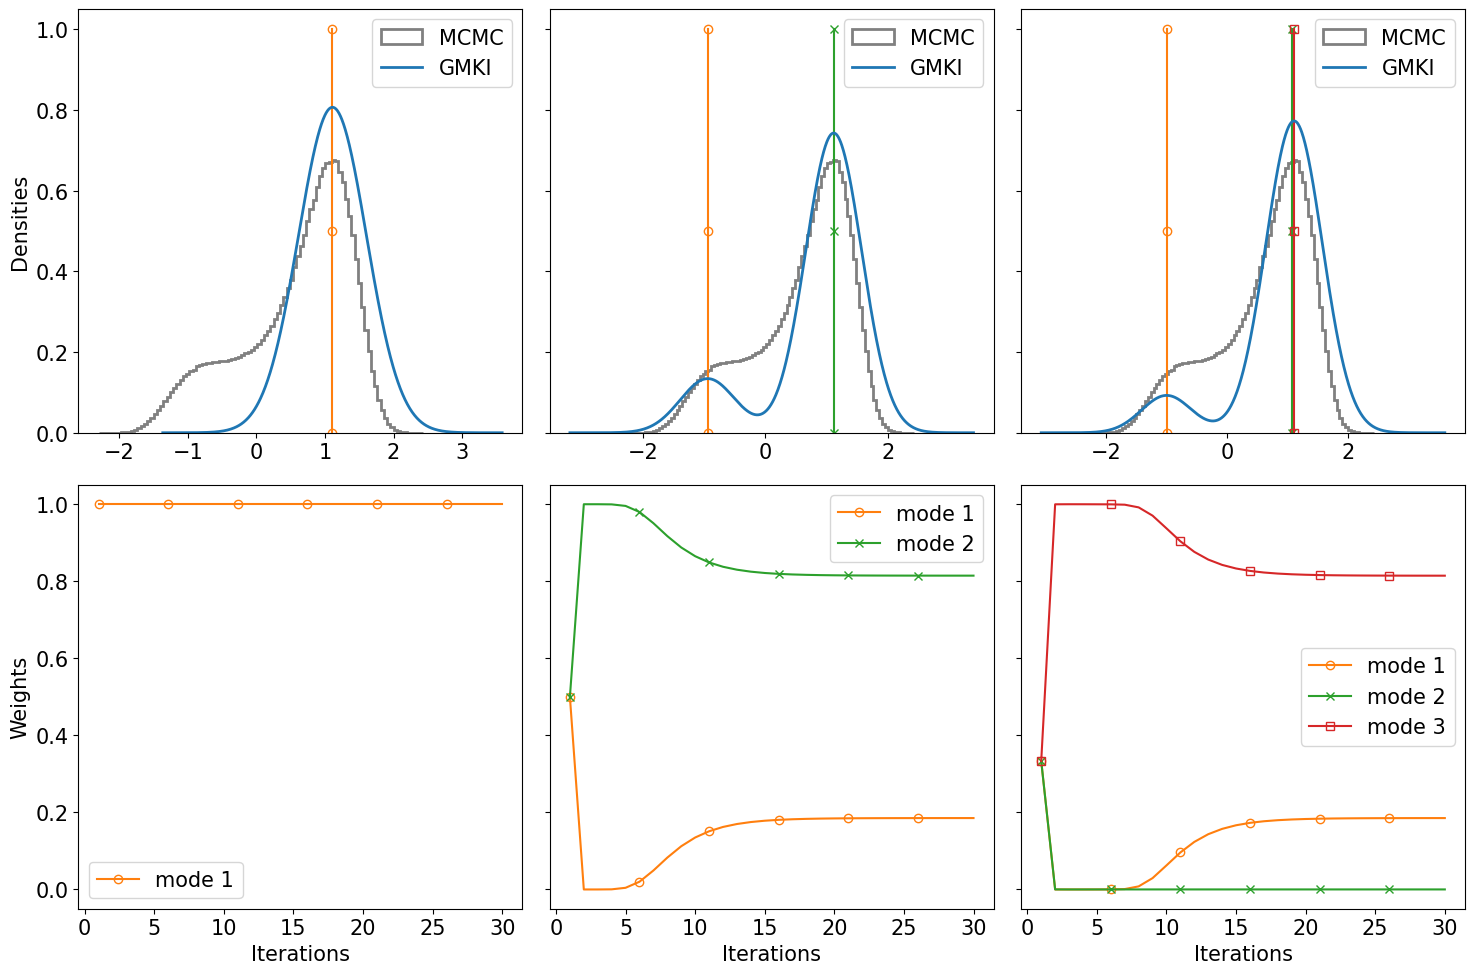

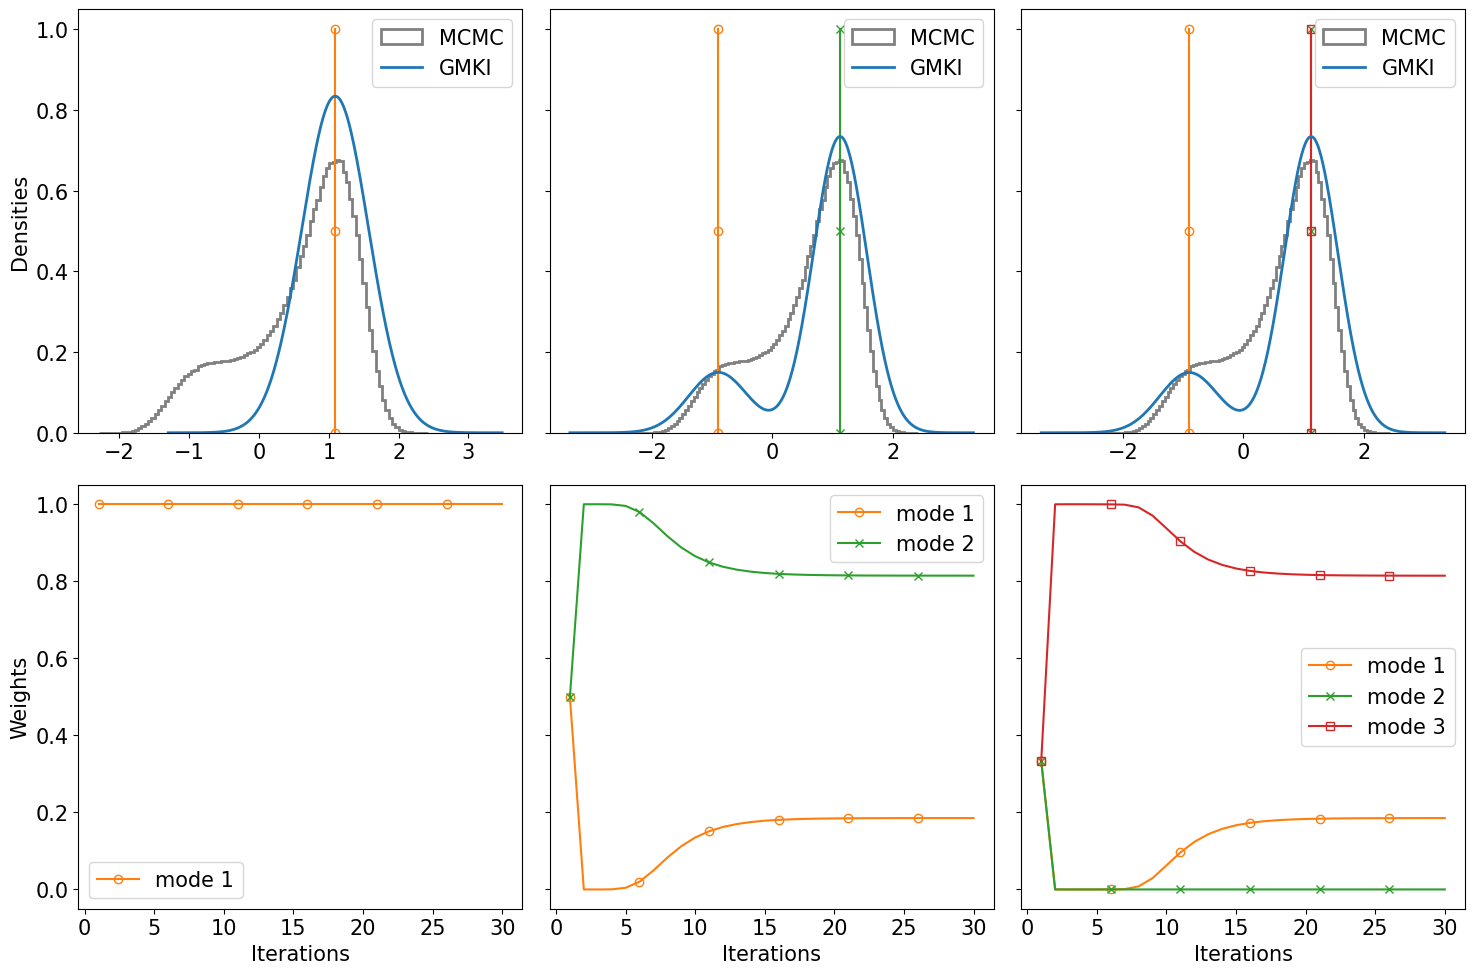

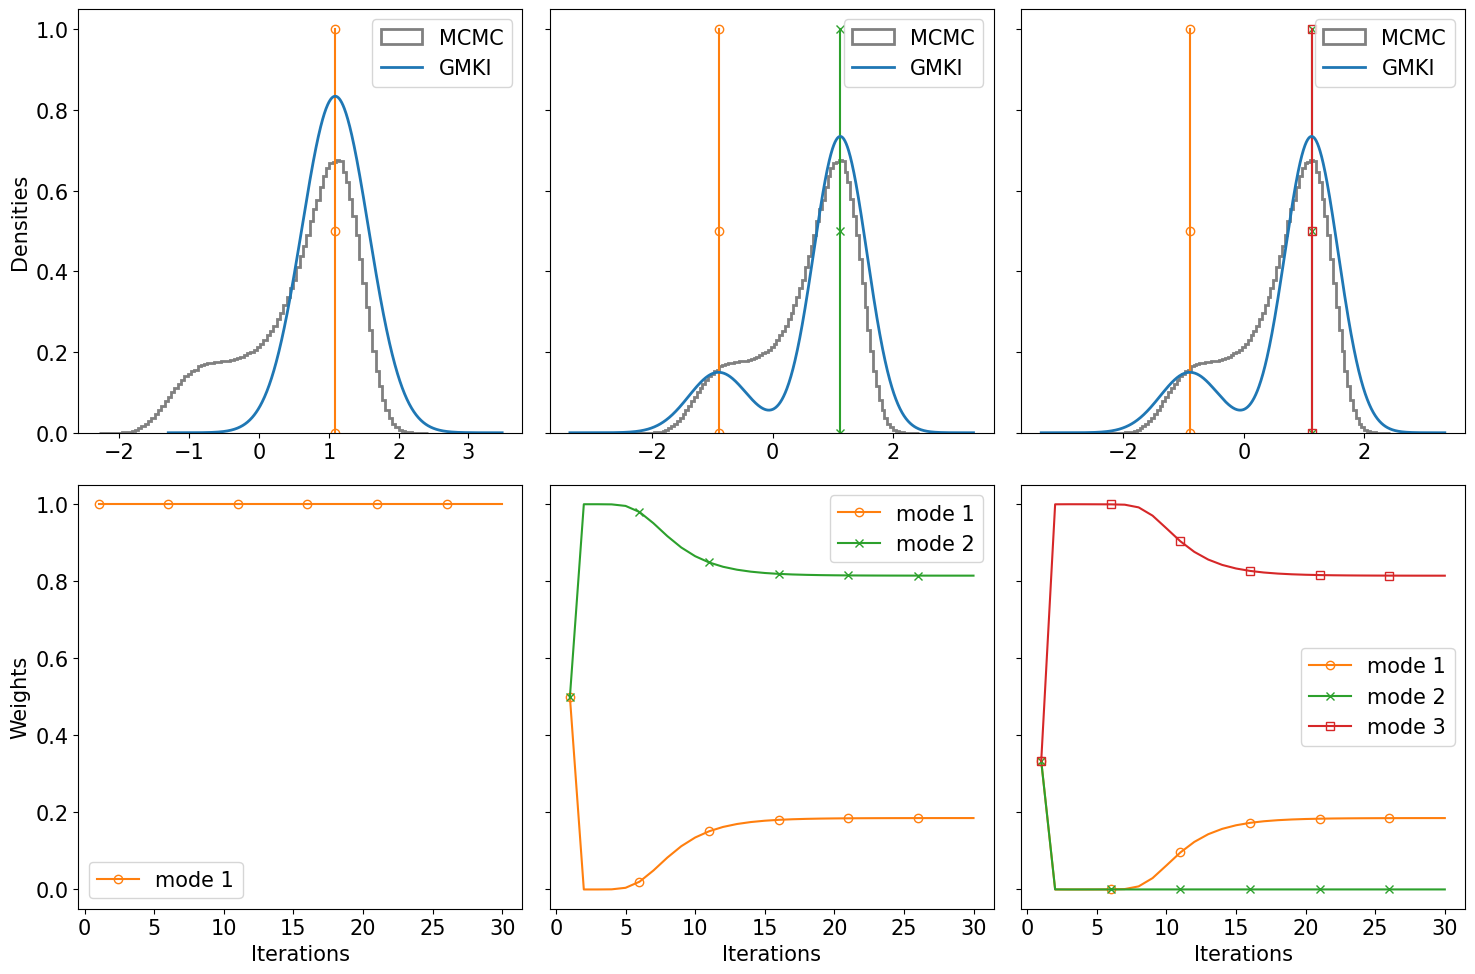

┌ Info: Start 
└ @ Main In[3]:3
┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81


In [7]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, Run_SMC = false, plot_every = 5) 

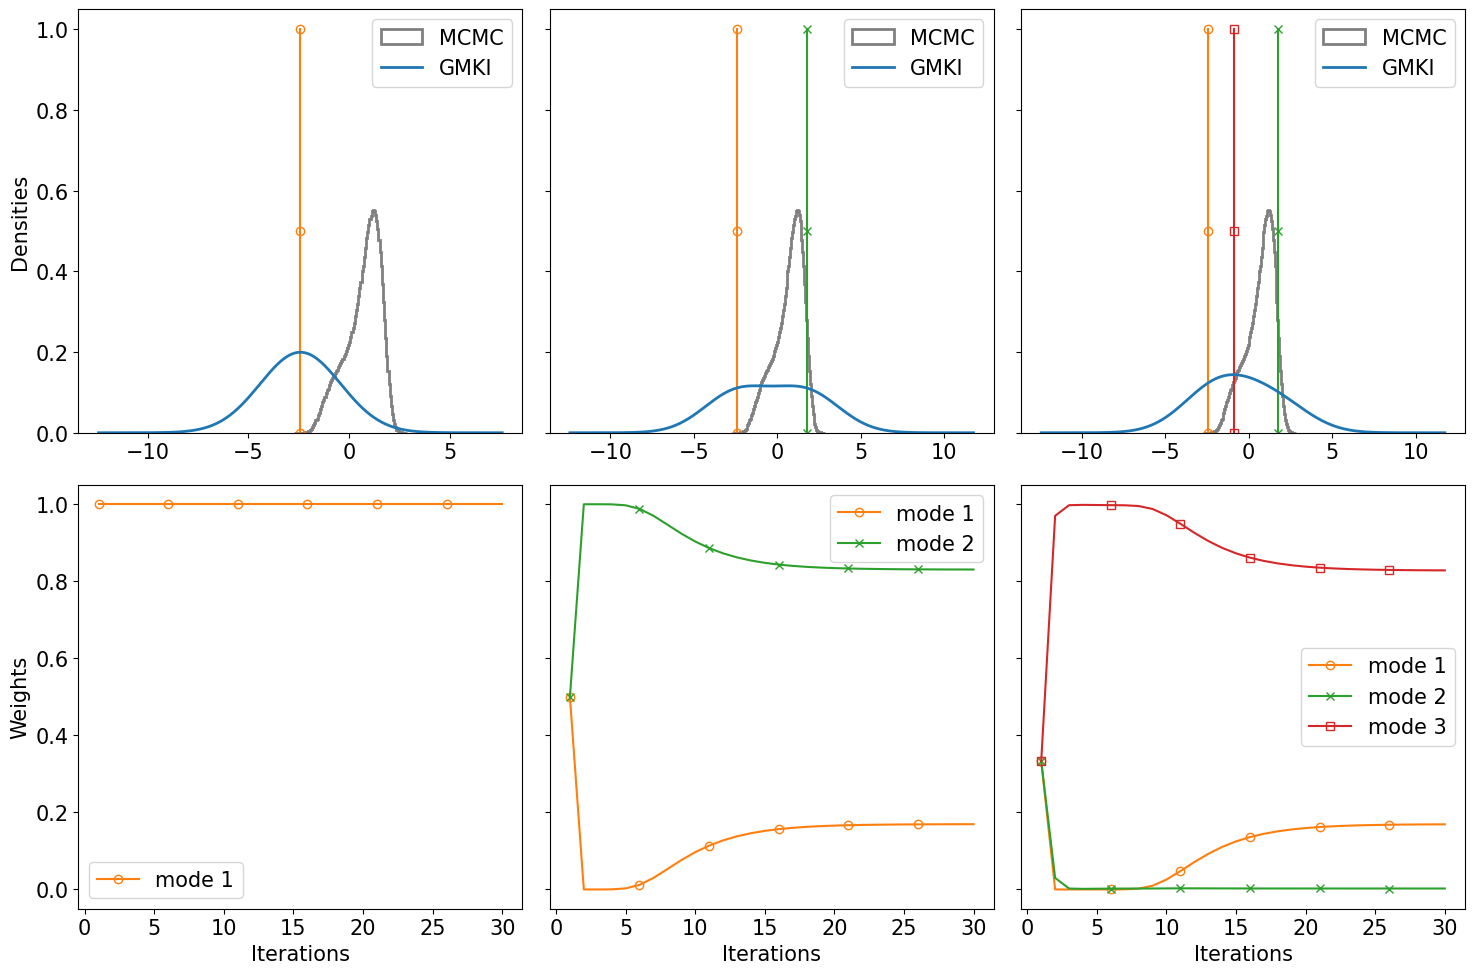

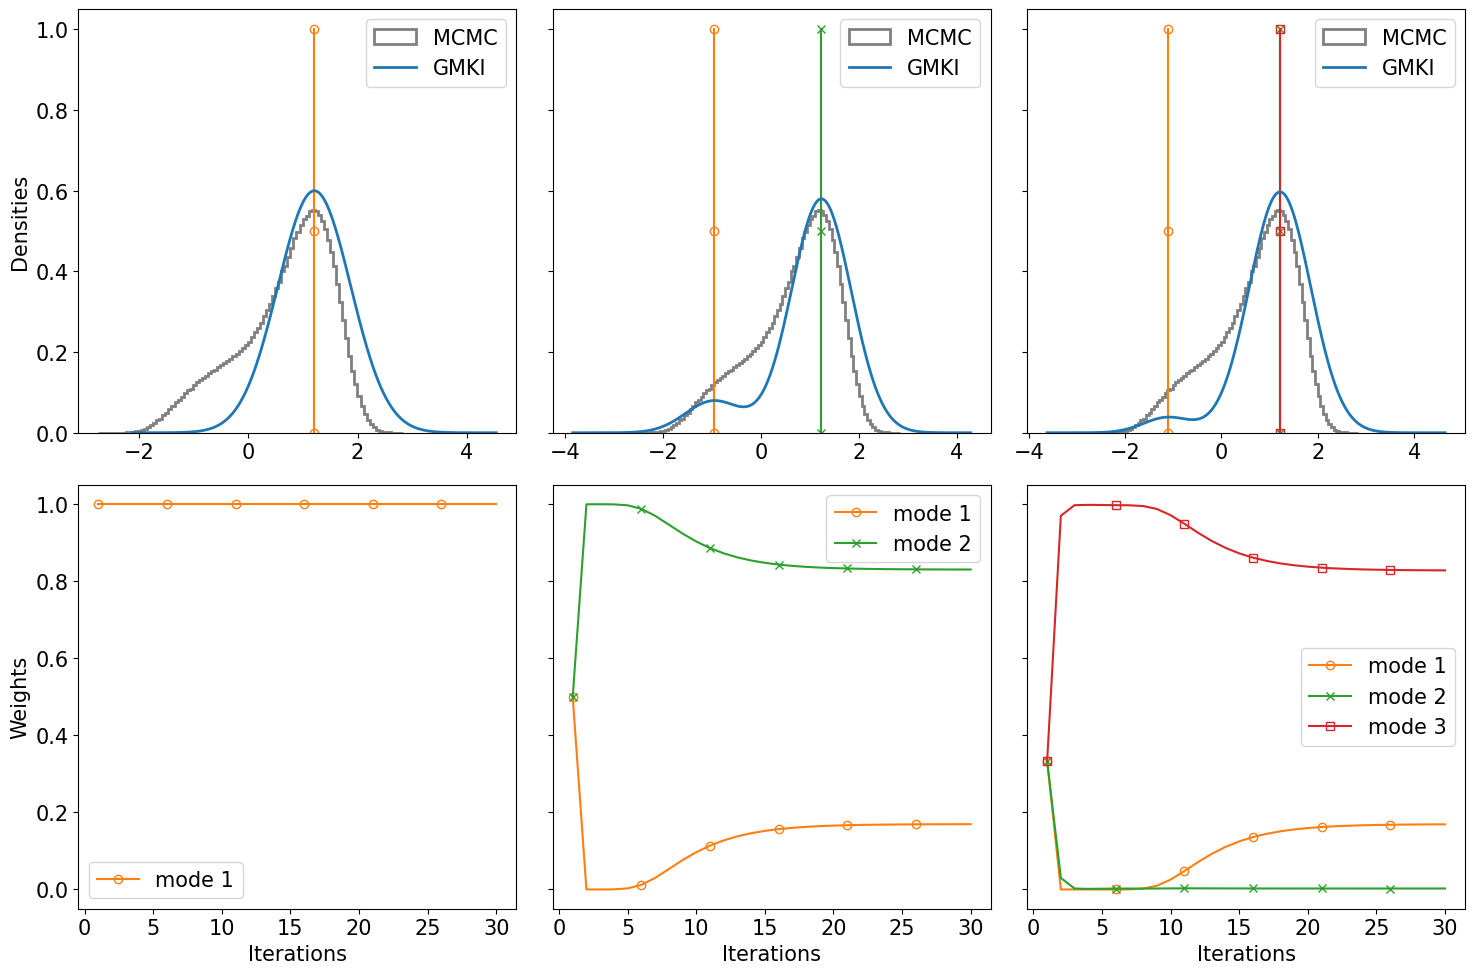

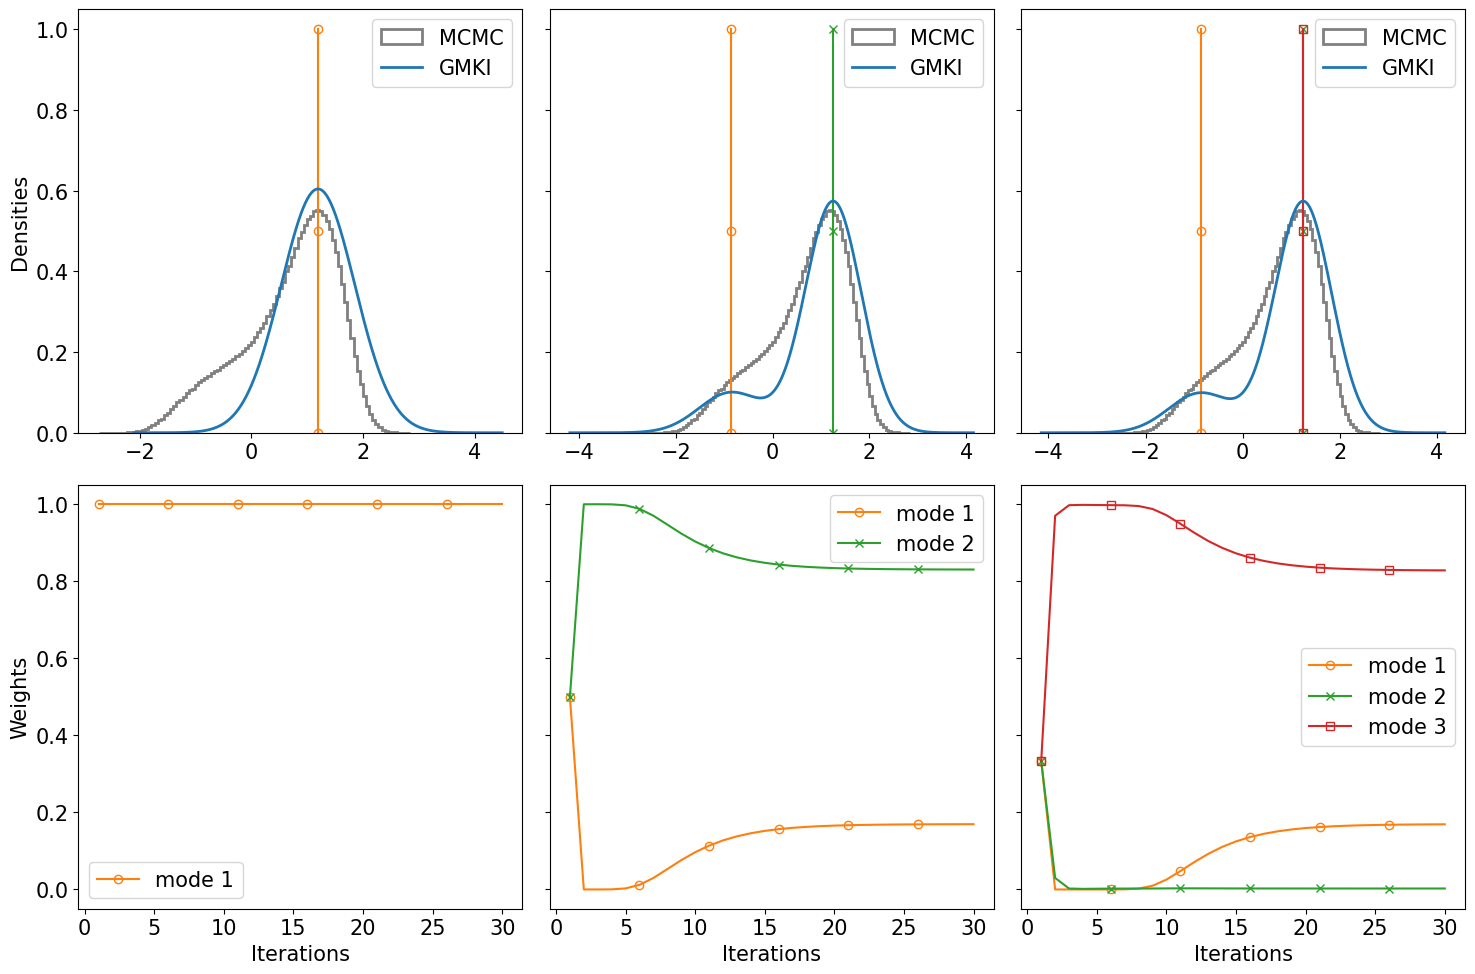

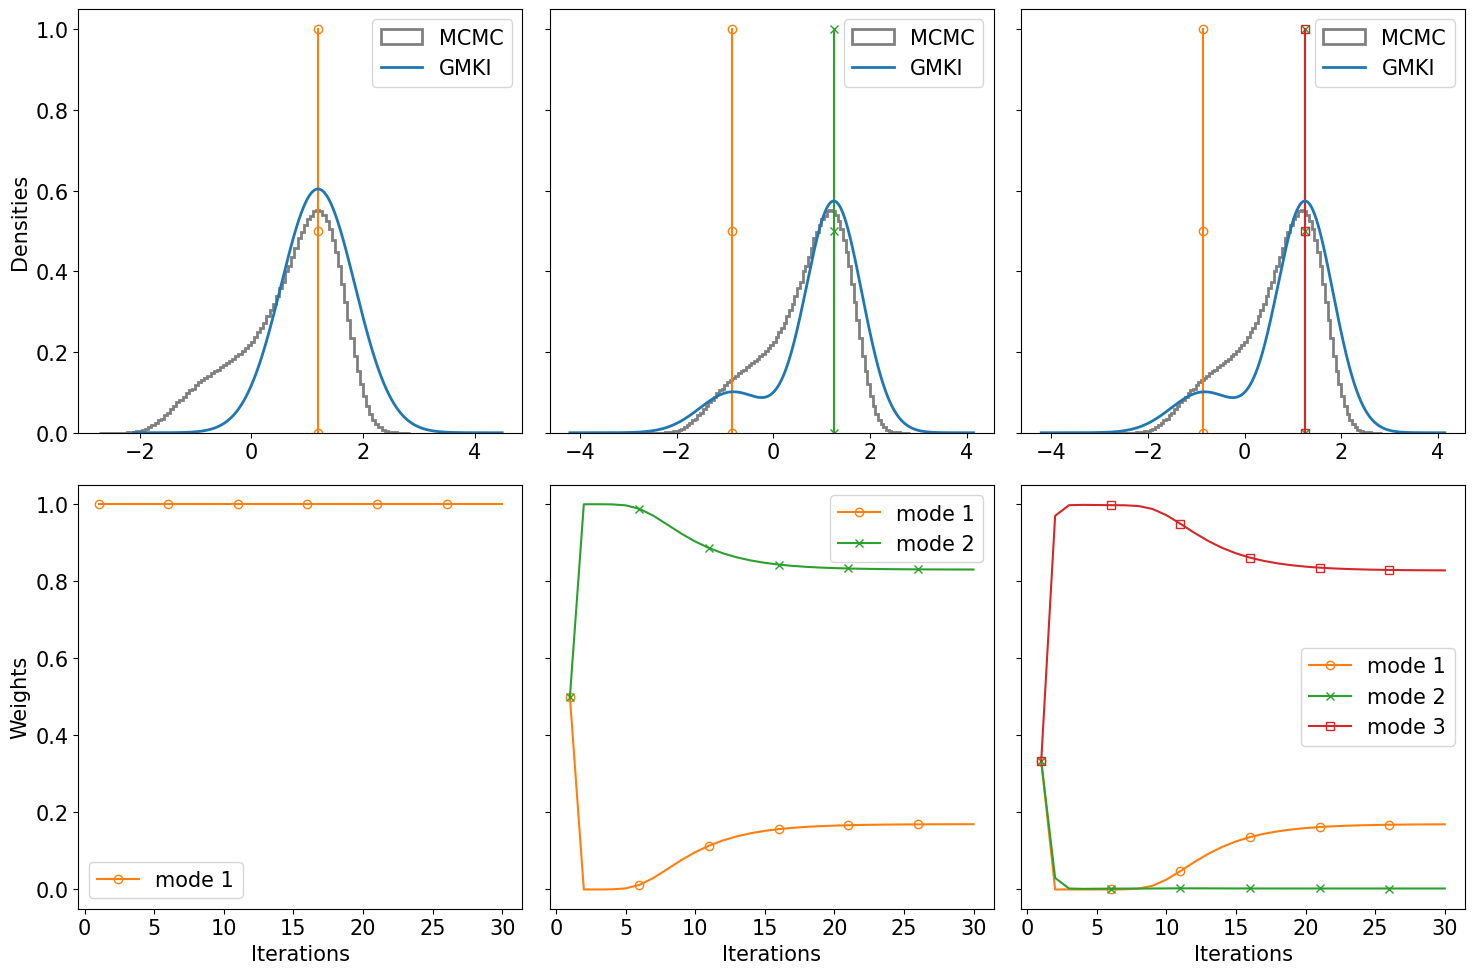

┌ Info: Start 
└ @ Main In[3]:3
┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:35
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81


In [6]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.5, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, Run_SMC = false, plot_every = 5) 